<a href="https://colab.research.google.com/github/neuroqudit/pyngn/blob/main/notebooks/04_structural_plasticity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 04. Structural Plasticity (Microglia)

This notebook demonstrates how Microglia prune synapses based on their "health", which is maintained by Hebbian-like activity tracking.

## Microglia Dynamics (Pruning)

Microglia optimize topology $M_{ij}$ by pruning energy-inefficient synapses.

### Synaptic Health
$$ H_{ij}(t+1) = H_{ij}(t) + \eta_{micro} \cdot (s_i(t) \cdot s_j(t) - \lambda \cdot H_{ij}(t)) $$
Health increases with correlated activity (Hebbian) and decays over time.

### Pruning
$$ M_{ij} = 1 \quad \text{if } H_{ij} \geq \theta_{prune} $$
$$ M_{ij} = 0 \quad \text{if } H_{ij} < \theta_{prune} $$

In [ ]:
!pip install pyngn

In [2]:
import torch
import matplotlib.pyplot as plt
from pyngn.glia import MicrogliaController

%matplotlib inline

## Setup Controller

We simulate a small network of 3 neurons. We will force correlated activity between neuron 0 and 1, but not 0 and 2.

In [3]:
n_neurons = 3
micro = MicrogliaController(n_neurons, pruning_threshold=0.5, eta_micro=0.1, health_decay=0.1)

health_trace_01 = [] # Connection 1 -> 0 (or 0 -> 1 depending on matrix def)
health_trace_02 = [] # Connection 2 -> 0

# Initial state: All connected (Mask=1)
print("Initial Mask:\n", micro.mask)

# Simulation Loop
for t in range(100):
    # Correlated activity for 0 and 1
    # Uncorrelated/Silent for 2

    # Spikes at time t
    # 0 and 1 fire together every other step
    fire = float(t % 2 == 0)
    spikes = torch.tensor([fire, fire, 0.0])

    # Update Microglia
    # We pass spikes as both pre and post for simplicity in this fully connected demo
    mask = micro.update(spikes, spikes)

    # Track health of connection 0-1 (index [0, 1]) and 0-2 (index [0, 2])
    health_trace_01.append(micro.health[0, 1].item())
    health_trace_02.append(micro.health[0, 2].item())

print("Final Mask:\n", micro.mask)

Initial Mask:
 tensor([[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]])
Final Mask:
 tensor([[1., 1., 0.],
        [1., 1., 0.],
        [0., 0., 0.]])


## Visualization

We expect the health of the correlated connection (0-1) to stay high, while the uncorrelated one (0-2) decays until it is pruned.

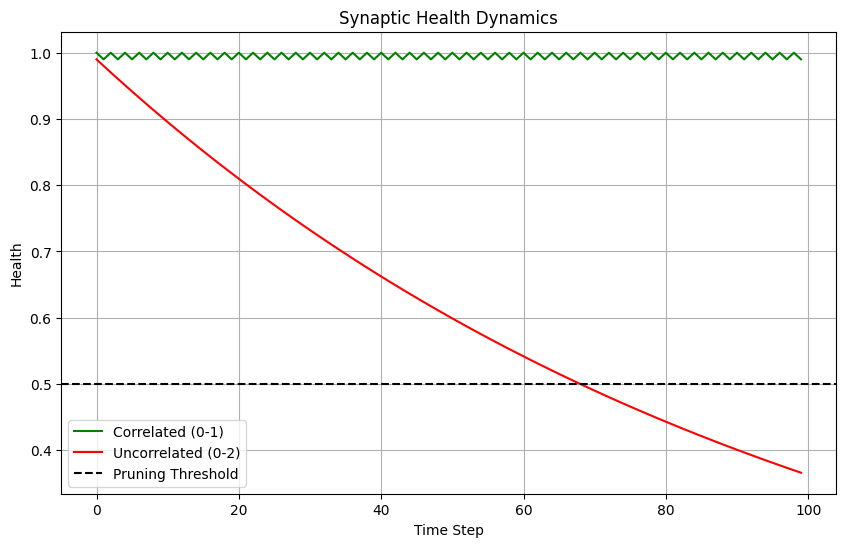

In [4]:
plt.figure(figsize=(10, 6))
plt.plot(health_trace_01, label='Correlated (0-1)', color='green')
plt.plot(health_trace_02, label='Uncorrelated (0-2)', color='red')
plt.axhline(0.5, color='k', linestyle='--', label='Pruning Threshold')
plt.title('Synaptic Health Dynamics')
plt.xlabel('Time Step')
plt.ylabel('Health')
plt.legend()
plt.grid(True)
plt.show()